In [1]:
from dataset1 import *
import numpy as np
from scipy.linalg import solve_triangular
from numpy.linalg import eigh
import torch
from hadamard_transform import hadamard_transform
import time
import pandas as pd
import seaborn as sns
#test

## Define functions

Sequential Nystrom

In [2]:

def getError(A,B):
    '''
    measure error as suggested in section 2.
    '''
    return np.linalg.norm(A-B,ord='nuc')/np.linalg.norm(A,ord='nuc')

def fjlt(A, D, indices, direction):
    """
    Applies the Fast Johnson-Lindenstrauss Transform (FJLT) to a square matrix.

    Parameters:
    - A: Input square matrix (NumPy array of size n x m).
    - D: Diagonal vector of +1 and -1 (NumPy array of size n).
    - indices: Indices of the selected rows or columns for subsampling (NumPy array of size l).
    - direction: 'left' to apply FJLT from the left (on rows) or 'right' for the transpose case (on columns).

    Returns:
    - A_proj: Transformed matrix after applying FJLT and subsampling.
    """
    n, m = A.shape
    l = indices.shape[0]  # Sketch size
    if direction == 'left':  # FJLT applied to the rows of A
        assert len(D) == n, "The length of D must match the number of rows in A."
        assert (n & (n - 1) == 0), "The number of rows in A must be a power of 2."
        # Multiply each row of A by the corresponding element in D
        OmegaA = A * D[:, np.newaxis]
        # Apply the Fast Hadamard Transform to the rows
        OmegaA = hadamard_transform(torch.tensor(OmegaA.T)).numpy().T
        # Subsample the rows and scale
        OmegaA = OmegaA[indices, :] * np.sqrt(n / l)
        return np.ascontiguousarray(OmegaA)
    elif direction == 'right':  # FJLT applied to the columns of A
        # Multiply each column of A by the corresponding element in D
        AOmega = A * D[np.newaxis, :]
        # Apply the Fast Hadamard Transform to the columns
        AOmega = hadamard_transform(torch.tensor(AOmega)).numpy()
        # Subsample the columns and scale
        AOmega = AOmega[:, indices] * np.sqrt(n / l)
        return np.ascontiguousarray(AOmega)

def getLowRank(A, rank, sketch_dim, sketch_method='gaussian', good_conditionned=True, print_times=False):
    """
    Compute a low-rank approximation of the matrix A using sketching, 
    eigenvalue decomposition, and truncation. Optionally prints the time taken for each major operation.

    Parameters:
        A (numpy.ndarray): Original matrix (size m x n).
        rank (int): Desired rank for the approximation.
        sketch_dim (int): Dimension of the sketching subspace.
        sketch_method (str): Method used for sketching. Options are:
                             - 'gaussian': Uses a Gaussian random matrix for sketching.
                             - 'fjlt': Uses the Fast Johnson-Lindenstrauss Transform.
        good_conditionned (bool): If True, uses Cholesky decomposition for better conditioning. 
                                  Otherwise, uses eigenvalue decomposition.
        print_times (bool): If True, prints the time taken for each major operation.

    Returns:
        A_nyst_k (numpy.ndarray): Low-rank approximation of A (size m x m).
    """
    m = A.shape[0]
    B = None
    C = None

    start_time = time.time()

    # Apply sketching based on the selected method
    if sketch_method == 'fjlt':  # Use Fast Johnson-Lindenstrauss Transform for sketching
        D = np.random.choice([1, -1], size=m)
        indices = np.random.choice(m, size=sketch_dim, replace=False)
        sketch_start = time.time()
        C = fjlt(A, D, indices, direction='right')
        B = fjlt(C, D, indices, direction='left')
        if print_times:
            print(f"FJLT sketching completed in {time.time() - sketch_start:.6f} seconds.")

    elif sketch_method == 'gaussian':  # Use Gaussian random matrix for sketching
        Omega = np.random.normal(size=(m, sketch_dim))
        sketch_start = time.time()
        C = A @ Omega
        B = Omega.T @ C
        if print_times:
            print(f"Gaussian sketching completed in {time.time() - sketch_start:.6f} seconds.")
    else:
        raise ValueError("Méthode de sketching non reconnue. Choisissez 'gaussian' ou 'fjlt'.")

    if good_conditionned:
        # Use Cholesky decomposition
        cholesky_start = time.time()
        L = np.linalg.cholesky(B)
        if print_times:
            print(f"Cholesky decomposition completed in {time.time() - cholesky_start:.6f} seconds.")
        
        triangular_start = time.time()
        Z = solve_triangular(L, C.T, lower=True).T
        if print_times:
            print(f"Triangular solve completed in {time.time() - triangular_start:.6f} seconds.")
    else:
        # Use eigenvalue decomposition
        eigh_start = time.time()
        eig_v, V = eigh(B)
        if print_times:
            print(f"Eigenvalue decomposition completed in {time.time() - eigh_start:.6f} seconds.")
        
        truncate_start = time.time()
        truncate = eig_v > 0
        eig_v = eig_v[truncate]
        V = V[:, truncate]
        Z = C @ (V * (1 / np.sqrt(eig_v)))
        if print_times:
            print(f"Eigenvalue truncation and normalization completed in {time.time() - truncate_start:.6f} seconds.")

    qr_start = time.time()
    Q, R = np.linalg.qr(Z)
    if print_times:
        print(f"QR decomposition completed in {time.time() - qr_start:.6f} seconds.")

    svd_start = time.time()
    U, Sigma, _ = np.linalg.svd(R)
    if print_times:
        print(f"SVD completed in {time.time() - svd_start:.6f} seconds.")

    approx_start = time.time()
    U_hat = Q @ U[:, :rank]
    A_nyst_k = (U_hat * Sigma[:rank]**2) @ U_hat.T
    if print_times:
        print(f"Low-rank approximation construction completed in {time.time() - approx_start:.6f} seconds.")

    total_time = time.time() - start_time
    if print_times:
        print(f"Total computation time: {total_time:.6f} seconds.")
    error = getError(A,A_nyst_k)
    print(f"Error :{error}".format(error))
    print(f"Total computation time: {total_time:.6f} seconds.")
    return total_time, A_nyst_k, error 

### Tests

In [3]:
n = 2048
A = getExpMatrix(n,R=10)
print(A.shape)

(2048, 2048)


In [4]:
getLowRank(A,rank=128,sketch_dim=128,sketch_method='gaussian',good_conditionned=False,print_times=True)

Gaussian sketching completed in 0.025328 seconds.
Eigenvalue decomposition completed in 0.007204 seconds.
Eigenvalue truncation and normalization completed in 0.002341 seconds.
QR decomposition completed in 0.027058 seconds.
SVD completed in 0.005277 seconds.
Low-rank approximation construction completed in 0.031770 seconds.
Total computation time: 0.114745 seconds.
Error :8.9732629702425e-15
Total computation time: 0.114745 seconds.


(0.11474490165710449,
 array([[ 1.00000000e+00, -6.24500451e-17,  3.81639165e-16, ...,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
        [-1.38777878e-17,  1.00000000e+00, -1.66533454e-16, ...,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
        [ 3.60822483e-16, -1.66533454e-16,  1.00000000e+00, ...,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
        ...,
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00]]),
 8.9732629702425e-15)

## Section 1

## Section 2

We'll compute the error with respect to three matrices. 
1. polynomial decay (dimension 1024 * 1024) locates: 
2. exp decay locates:
3. ../Dataset/A_3_dataset_2_mnist.npy 
    denotes the matrix obtained from MNIST, with c=100
4. ../... mnist.npy with c = 10.

All four matrices are of dimension $1024 \times 1024$,
and then we try all of four with dimension $4096 \times 4096$.

In [7]:
# Loading matrices

loadMatrix_A_1 = np.load("../Dataset/Matrices/A_1_n2048_polyDecayMatrix.npy")
print("matrix A_1")
print(loadMatrix_A_1.shape)
print(loadMatrix_A_1[:10,:5])

loadMatrix_A_2 = np.load("../Dataset/Matrices/A_2_n2048_expDecayMatrix.npy")
print("matrix A_2")
print(loadMatrix_A_2.shape)
print(loadMatrix_A_2[:10,:5])

loadMatrix_A_3 = np.load("../Dataset/Matrices/A_3_dataset_2_mnist_n2048_c100.npy")
print("matrix A_3")
print(loadMatrix_A_3.shape)
print(loadMatrix_A_3[:10,:5])

loadMatrix_A_32 = np.load("../Dataset/Matrices/A_3_dataset_2_mnist_n2048_c10.npy")
print("matrix A_32")
print(loadMatrix_A_32.shape)
print(loadMatrix_A_32[:10,:5])




matrix A_1
(2048, 2048)
[[1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]]
matrix A_2
(2048, 2048)
[[1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]]
matrix A_3
(2048, 2048)
[[1.         0.99127504 0.98824289 0.99001237 0.98907651]
 [0.99127504 1.         0.98715919 0.98829865 0.98930957]
 [0.98824289 0.98715919 1.         0.9898814  0.98994457]
 [0.99001237 0.98829865 0.9898814  1.         0.99126262]
 [0.98907651 0.98930957 0.98994457 0.99126262 1.        ]
 [0.98979753 0.98903161 0.98938555 0.99024257 0.99195122]
 [0.99100754 0.98756737 0.98972827 0.991512   0.9925866 ]
 [0.99278471 0.98967594 0.98934556 0.98962114 0.98935745]
 [0.99136177 0.98870132 0.99122707 0.99290202 0.9940263 ]
 [0.98989935 0.98824599 0.99277739 0.9911983

In [9]:
from tqdm import tqdm  # For progress tracking

def collect_low_rank_errors(
    A, 
    sketch_dims=[2, 4, 8, 16, 32, 64, 128], 
    is_good_conditionned=False, 
    sketch_method='gaussian', 
    output_file='Section_2_test_1_for_loadMatrixA_1.xlsx',
    matrix_name="MatrixA"
):
    """
    Computes errors for various ranks and sketch dimensions using the `getLowRank` function.

    Parameters:
    - A (np.ndarray): Input matrix.
    - sketch_dims (list of int): List of sketch dimensions to test.
    - is_good_conditionned (bool): Whether to use good-conditioned matrices in `getLowRank`.
    - sketch_method (str): Method for sketching ('gaussian' or other supported by `getLowRank`).
    - output_file (str): Path to the file where results are saved (.csv or .xlsx).
    - matrix_name (str): Name or identifier of the input matrix.

    Saves:
    - Results to a file with columns: "Sketch Dimension", "Approximation Rank", "Error Value",
      "Sketch Method", "Matrix Name".
    """
    print(A.shape)
    results = []
    
    # Iterate over each sketch_dim
    for sketch_dim in tqdm(sketch_dims, desc="Sketch Dimensions Progress", unit="dim"):
        ranks = list(range(0, sketch_dim + 1, 5))  # Generate ranks from 0 with step 10 up to sketch_dim
        for rank in ranks:
            # Compute the error for each rank
            _, _, error = getLowRank(
                A=A, 
                rank=rank, 
                sketch_dim=sketch_dim, 
                sketch_method=sketch_method, 
                good_conditionned=is_good_conditionned
            )
            # Append the result
            results.append({
                'Sketch Dimension': sketch_dim,
                'Approximation Rank': rank,
                'Error Value': error,
                'Sketch Method': sketch_method,
                'Matrix Name': matrix_name
            })
    
    # Convert results to a DataFrame for easier manipulation
    df = pd.DataFrame(results)

    # Save results to file
    if output_file.endswith('.csv'):
        df.to_csv(output_file, index=False)
    elif output_file.endswith('.xlsx'):
        df.to_excel(output_file, index=False, engine='openpyxl')
    else:
        raise ValueError("Output file must be either .csv or .xlsx.")
    
    print(f"Results saved to {output_file}.")



In [ ]:
# collect_low_rank_errors(loadMatrix_A_1)
testList1 = [25, 50, 75, 100, 125, 150]
testList2 = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
testList3 = [25, 50, 75, 100, 125, 150, 175, 200]
testList4 = [5, 10, 15, 20, 25]
# [50, 100, 150, 200]
# [25, 50, 75, 100]


collect_low_rank_errors(A = loadMatrix_A_1, 
                        sketch_dims = testList4,  
                        is_good_conditionned=True, 
                        sketch_method='gaussian', 
                        output_file='../Dataset/Section_2_test_3_Gaussian_for_loadMatrixA_1.csv', matrix_name="loadMatrix_A_1")

collect_low_rank_errors(A = loadMatrix_A_2, 
                        sketch_dims = testList4,  
                        is_good_conditionned=False, 
                        sketch_method='gaussian', 
                        output_file='../Dataset/Section_2_test_3_Gaussian_for_loadMatrixA_2.csv', matrix_name="loadMatrix_A_2")

collect_low_rank_errors(A = loadMatrix_A_3, 
                        sketch_dims = testList4,  
                        is_good_conditionned=False, 
                        sketch_method='gaussian', 
                        output_file='../Dataset/Section_2_test_3_Gaussian_for_loadMatrixA_3.csv', matrix_name="loadMatrix_A_3")

collect_low_rank_errors(A = loadMatrix_A_32, 
                        sketch_dims = testList4,  
                        is_good_conditionned=False, 
                        sketch_method='gaussian', 
                        output_file='../Dataset/Section_2_test_3_Gaussian_for_loadMatrixA_32.csv', matrix_name="loadMatrix_A_3")

collect_low_rank_errors(A = loadMatrix_A_1, 
                        sketch_dims = testList4,  
                        is_good_conditionned=True, 
                        sketch_method='fjlt', 
                        output_file='../Dataset/Section_2_test_4_fjlt_for_loadMatrixA_1.csv', matrix_name="loadMatrix_A_1")

collect_low_rank_errors(A = loadMatrix_A_2, 
                        sketch_dims = testList4,  
                        is_good_conditionned=False, 
                        sketch_method='fjlt', 
                        output_file='../Dataset/Section_2_test_4_fjlt_for_loadMatrixA_2.csv', matrix_name="loadMatrix_A_2")

collect_low_rank_errors(A = loadMatrix_A_3, 
                        sketch_dims = testList4,  
                        is_good_conditionned=False, 
                        sketch_method='fjlt', 
                        output_file='../Dataset/Section_2_test_4_fjlt_for_loadMatrixA_3.csv', matrix_name="loadMatrix_A_3")

collect_low_rank_errors(A = loadMatrix_A_32, 
                        sketch_dims = testList4,  
                        is_good_conditionned=False, 
                        sketch_method='fjlt', 
                        output_file='../Dataset/Section_2_test_4_fjlt_for_loadMatrixA_32.csv', matrix_name="loadMatrix_A_32")


(2048, 2048)


Sketch Dimensions Progress:   0%|          | 0/4 [00:00<?, ?dim/s]

Error :1.0
Total computation time: 0.051919 seconds.
Error :0.9566319951438352
Total computation time: 0.033713 seconds.


Sketch Dimensions Progress:  25%|██▌       | 1/4 [00:12<00:36, 12.21s/dim]

Error :0.9391116511278508
Total computation time: 0.035801 seconds.
Error :1.0
Total computation time: 0.066856 seconds.
Error :0.9389997176963862
Total computation time: 0.063310 seconds.
Error :0.919278269475662
Total computation time: 0.063120 seconds.
Error :0.905495434598828
Total computation time: 0.071293 seconds.


Sketch Dimensions Progress:  50%|█████     | 2/4 [00:33<00:35, 17.74s/dim]

Error :0.8941005305572016
Total computation time: 0.072456 seconds.
Error :1.0
Total computation time: 0.103167 seconds.
Error :0.9262161214168391
Total computation time: 0.094536 seconds.
Error :0.9060497298567469
Total computation time: 0.104191 seconds.
Error :0.8890822702131548
Total computation time: 0.101935 seconds.
Error :0.8761011198786884
Total computation time: 0.102832 seconds.
Error :0.864337555947316
Total computation time: 0.105292 seconds.


Sketch Dimensions Progress:  75%|███████▌  | 3/4 [01:02<00:22, 22.64s/dim]

Error :0.8548090569514635
Total computation time: 0.111507 seconds.
Error :1.0
Total computation time: 0.149412 seconds.
Error :0.9182319738054034
Total computation time: 0.138450 seconds.
Error :0.8957518285520124
Total computation time: 0.136599 seconds.
Error :0.8774070194733662
Total computation time: 0.137011 seconds.
Error :0.8620129497094408
Total computation time: 0.140301 seconds.
Error :0.8499266357830404
Total computation time: 0.156149 seconds.
Error :0.8392273932565535
Total computation time: 0.137552 seconds.
Error :0.8282450065730274
Total computation time: 0.153088 seconds.


Sketch Dimensions Progress: 100%|██████████| 4/4 [01:39<00:00, 24.97s/dim]


Error :0.818355379815742
Total computation time: 0.145397 seconds.
Results saved to ../Dataset/Section_2_test_3_Gaussian_for_loadMatrixA_1.csv.
(2048, 2048)


Sketch Dimensions Progress:   0%|          | 0/4 [00:00<?, ?dim/s]

Error :1.0
Total computation time: 0.033589 seconds.
Error :0.004463737974510018
Total computation time: 0.033295 seconds.


Sketch Dimensions Progress:  25%|██▌       | 1/4 [00:11<00:34, 11.36s/dim]

Error :0.0001703090049340177
Total computation time: 0.032977 seconds.
Error :1.0
Total computation time: 0.065965 seconds.
Error :0.004358007309388388
Total computation time: 0.061244 seconds.
Error :1.3782958619987883e-05
Total computation time: 0.073243 seconds.
Error :4.587711840178045e-08
Total computation time: 0.064332 seconds.


Sketch Dimensions Progress:  50%|█████     | 2/4 [00:31<00:33, 16.69s/dim]

Error :3.515674588440485e-09
Total computation time: 0.066120 seconds.
Error :1.0
Total computation time: 0.102109 seconds.
Error :0.004358006657756128
Total computation time: 0.094347 seconds.
Error :1.3781227150786872e-05
Total computation time: 0.098385 seconds.
Error :4.358011580484786e-08
Total computation time: 0.113912 seconds.
Error :1.3787716853961684e-10
Total computation time: 0.106047 seconds.
Error :5.464115880290324e-13
Total computation time: 0.109815 seconds.


Sketch Dimensions Progress:  75%|███████▌  | 3/4 [01:00<00:21, 21.97s/dim]

Error :1.0868102241738614e-13
Total computation time: 0.144480 seconds.
Error :1.0
Total computation time: 0.136158 seconds.
Error :0.004358006657737554
Total computation time: 0.129795 seconds.
Error :1.3781227109128376e-05
Total computation time: 0.125418 seconds.
Error :4.3580087884064766e-08
Total computation time: 0.153208 seconds.
Error :1.378401621672577e-10
Total computation time: 0.136785 seconds.
Error :4.997446581707998e-13
Total computation time: 0.132560 seconds.
Error :6.113984915211618e-14
Total computation time: 0.149854 seconds.
Error :1.3661522150915506e-13
Total computation time: 0.187606 seconds.


Sketch Dimensions Progress: 100%|██████████| 4/4 [01:39<00:00, 24.79s/dim]


Error :7.86735349933992e-14
Total computation time: 0.136458 seconds.
Results saved to ../Dataset/Section_2_test_3_Gaussian_for_loadMatrixA_2.csv.
(2048, 2048)


Sketch Dimensions Progress:   0%|          | 0/4 [00:00<?, ?dim/s]

Error :1.0
Total computation time: 0.033283 seconds.
Error :0.004284780867123946
Total computation time: 0.032272 seconds.


Sketch Dimensions Progress:  25%|██▌       | 1/4 [00:12<00:38, 12.72s/dim]

Error :0.0036435504240299
Total computation time: 0.033877 seconds.
Error :1.0
Total computation time: 0.061427 seconds.
Error :0.0035834687501027133
Total computation time: 0.061764 seconds.
Error :0.0025109165430759464
Total computation time: 0.062226 seconds.
Error :0.0021331712084719356
Total computation time: 0.069289 seconds.


Sketch Dimensions Progress:  50%|█████     | 2/4 [00:35<00:37, 18.57s/dim]

Error :0.00202563899588575
Total computation time: 0.071099 seconds.
Error :1.0
Total computation time: 0.106386 seconds.
Error :0.0033715904520826077
Total computation time: 0.111978 seconds.
Error :0.002127569195199368
Total computation time: 0.136583 seconds.
Error :0.0016880409896236786
Total computation time: 0.122584 seconds.
Error :0.0014664172335235963
Total computation time: 0.138433 seconds.
Error :0.0013411472027104357
Total computation time: 0.108923 seconds.


Sketch Dimensions Progress:  75%|███████▌  | 3/4 [01:07<00:24, 24.78s/dim]

Error :0.0012687274433958264
Total computation time: 0.126048 seconds.
Error :1.0
Total computation time: 0.148982 seconds.
Error :0.0032762244313905226
Total computation time: 0.147552 seconds.
Error :0.0019767836255817598
Total computation time: 0.148124 seconds.
Error :0.0014550295881629299
Total computation time: 0.148508 seconds.
Error :0.0012029033318064456
Total computation time: 0.167718 seconds.
Error :0.001050973876517074
Total computation time: 0.154613 seconds.
Error :0.0009532146072005876
Total computation time: 0.161929 seconds.
Error :0.0008963473742778927
Total computation time: 0.173100 seconds.


Sketch Dimensions Progress: 100%|██████████| 4/4 [01:47<00:00, 26.92s/dim]


Error :0.0008666502535388373
Total computation time: 0.171824 seconds.
Results saved to ../Dataset/Section_2_test_3_Gaussian_for_loadMatrixA_3.csv.
(2048, 2048)


Sketch Dimensions Progress:   0%|          | 0/4 [00:00<?, ?dim/s]

Error :1.0
Total computation time: 0.031520 seconds.
Error :0.45015374666971747
Total computation time: 0.040002 seconds.


Sketch Dimensions Progress:  25%|██▌       | 1/4 [00:12<00:38, 12.93s/dim]

Error :0.43376675199195336
Total computation time: 0.034842 seconds.
Error :1.0
Total computation time: 0.067318 seconds.
Error :0.40288465527863443
Total computation time: 0.069295 seconds.
Error :0.37111954870267316
Total computation time: 0.062844 seconds.
Error :0.3552519658073593
Total computation time: 0.077901 seconds.


Sketch Dimensions Progress:  50%|█████     | 2/4 [00:34<00:36, 18.26s/dim]

Error :0.34839008914437924
Total computation time: 0.076759 seconds.
Error :1.0
Total computation time: 0.103910 seconds.
Error :0.38410277945884397
Total computation time: 0.138328 seconds.
Error :0.3413358229764292
Total computation time: 0.123429 seconds.
Error :0.32545306445169986
Total computation time: 0.110446 seconds.
Error :0.31390361411796824
Total computation time: 0.110538 seconds.
Error :0.306076252936185
Total computation time: 0.149100 seconds.


Sketch Dimensions Progress:  75%|███████▌  | 3/4 [01:06<00:24, 24.47s/dim]

Error :0.30127668437186583
Total computation time: 0.165011 seconds.
Error :1.0
Total computation time: 0.176446 seconds.
Error :0.3736213567111973
Total computation time: 0.146659 seconds.
Error :0.3253273331932534
Total computation time: 0.164118 seconds.
Error :0.30315030161697476
Total computation time: 0.155054 seconds.
Error :0.29245968811514395
Total computation time: 0.149242 seconds.
Error :0.28229253849749925
Total computation time: 0.168432 seconds.
Error :0.2768285966314557
Total computation time: 0.164381 seconds.
Error :0.2734543997502124
Total computation time: 0.153139 seconds.


Sketch Dimensions Progress: 100%|██████████| 4/4 [01:45<00:00, 26.48s/dim]


Error :0.270344350582723
Total computation time: 0.154475 seconds.
Results saved to ../Dataset/Section_2_test_3_Gaussian_for_loadMatrixA_32.csv.
(2048, 2048)


Sketch Dimensions Progress:   0%|          | 0/4 [00:00<?, ?dim/s]

Error :1.0
Total computation time: 0.118585 seconds.
Error :0.9548059363466486
Total computation time: 0.079770 seconds.


Sketch Dimensions Progress:  25%|██▌       | 1/4 [00:12<00:37, 12.40s/dim]

Error :0.9393909285419388
Total computation time: 0.094422 seconds.
Error :1.0
Total computation time: 0.110292 seconds.
Error :0.9379846770441359
Total computation time: 0.094662 seconds.
Error :0.9201356832771251
Total computation time: 0.099423 seconds.
Error :0.9049781854806421
Total computation time: 0.110727 seconds.


Sketch Dimensions Progress:  50%|█████     | 2/4 [00:32<00:33, 16.86s/dim]

Error :0.8943217842985086
Total computation time: 0.135951 seconds.
Error :1.0
Total computation time: 0.215465 seconds.
Error :0.9264968013160044
Total computation time: 0.211601 seconds.
Error :0.904527743647951
Total computation time: 0.210253 seconds.
Error :0.8890654219981673
Total computation time: 0.200796 seconds.
Error :0.8754300920259444
Total computation time: 0.220638 seconds.
Error :0.8628764262764889
Total computation time: 0.201089 seconds.


Sketch Dimensions Progress:  75%|███████▌  | 3/4 [01:01<00:22, 22.38s/dim]

Error :0.8541974129811687
Total computation time: 0.203919 seconds.
Error :1.0
Total computation time: 0.270218 seconds.
Error :0.9187137182829105
Total computation time: 0.199366 seconds.
Error :0.8947026671612398
Total computation time: 0.176842 seconds.
Error :0.877086008931753
Total computation time: 0.183413 seconds.
Error :0.8623632065785177
Total computation time: 0.192679 seconds.
Error :0.850337346741
Total computation time: 0.187712 seconds.
Error :0.8374404732448315
Total computation time: 0.199667 seconds.
Error :0.829332871172734
Total computation time: 0.271070 seconds.


Sketch Dimensions Progress: 100%|██████████| 4/4 [01:38<00:00, 24.59s/dim]


Error :0.8180721155678571
Total computation time: 0.257757 seconds.
Results saved to ../Dataset/Section_2_test_4_fjlt_for_loadMatrixA_1.csv.
(2048, 2048)


Sketch Dimensions Progress:   0%|          | 0/4 [00:00<?, ?dim/s]

Error :1.0
Total computation time: 0.069550 seconds.
Error :0.011938676268251635
Total computation time: 0.083451 seconds.


Sketch Dimensions Progress:  25%|██▌       | 1/4 [00:12<00:38, 12.71s/dim]

Error :0.04788478257269537
Total computation time: 0.096196 seconds.
Error :1.0
Total computation time: 0.092762 seconds.
Error :0.005504178512104297
Total computation time: 0.121727 seconds.
Error :0.004781365238350252
Total computation time: 0.144851 seconds.
Error :0.0015947432340659225
Total computation time: 0.117443 seconds.


Sketch Dimensions Progress:  50%|█████     | 2/4 [00:33<00:34, 17.39s/dim]

Error :0.00012463300253176776
Total computation time: 0.119966 seconds.
Error :1.0
Total computation time: 0.180230 seconds.
Error :0.0043587498241383854
Total computation time: 0.127731 seconds.
Error :5.8435300446467386e-05
Total computation time: 0.125722 seconds.
Error :1.913437318887249e-06
Total computation time: 0.133324 seconds.
Error :0.0014930508563229697
Total computation time: 0.222478 seconds.
Error :0.0015054244519020251
Total computation time: 0.185393 seconds.


Sketch Dimensions Progress:  75%|███████▌  | 3/4 [01:01<00:22, 22.39s/dim]

Error :3.9858305210740486e-06
Total computation time: 0.140668 seconds.
Error :1.0
Total computation time: 0.166207 seconds.
Error :0.004359831369871426
Total computation time: 0.259093 seconds.
Error :2.2242727494510052e-05
Total computation time: 0.157124 seconds.
Error :5.390083805696009e-08
Total computation time: 0.250193 seconds.
Error :4.219250379795842e-05
Total computation time: 0.169086 seconds.
Error :4.820926210055389e-05
Total computation time: 0.181513 seconds.
Error :1.8739745690655186e-06
Total computation time: 0.271110 seconds.
Error :3.8044427239141104e-06
Total computation time: 0.251544 seconds.


Sketch Dimensions Progress: 100%|██████████| 4/4 [01:38<00:00, 24.69s/dim]


Error :1.8971755486635786e-06
Total computation time: 0.264929 seconds.
Results saved to ../Dataset/Section_2_test_4_fjlt_for_loadMatrixA_2.csv.
(2048, 2048)


Sketch Dimensions Progress:   0%|          | 0/4 [00:00<?, ?dim/s]

Error :1.0
Total computation time: 0.097707 seconds.
Error :0.004412135632419067
Total computation time: 0.085969 seconds.


Sketch Dimensions Progress:  25%|██▌       | 1/4 [00:14<00:42, 14.05s/dim]

Error :0.003539667502188358
Total computation time: 0.085958 seconds.
Error :1.0
Total computation time: 0.144287 seconds.
Error :0.0036108380379495887
Total computation time: 0.152287 seconds.
Error :0.002547529473810462
Total computation time: 0.110969 seconds.
Error :0.0021607543040650812
Total computation time: 0.104239 seconds.


Sketch Dimensions Progress:  50%|█████     | 2/4 [00:36<00:37, 18.85s/dim]

Error :0.0019868182983994566
Total computation time: 0.152050 seconds.
Error :1.0
Total computation time: 0.236888 seconds.
Error :0.0033742153822892648
Total computation time: 0.232806 seconds.
Error :0.0021406996995094875
Total computation time: 0.237206 seconds.
Error :0.0016909973410799914
Total computation time: 0.170450 seconds.
Error :0.0014420670672303378
Total computation time: 0.189720 seconds.
Error :0.0013309926313057009
Total computation time: 0.224440 seconds.


Sketch Dimensions Progress:  75%|███████▌  | 3/4 [01:08<00:24, 24.82s/dim]

Error :0.001276419890583988
Total computation time: 0.265346 seconds.
Error :1.0
Total computation time: 0.286251 seconds.
Error :0.00328393194177279
Total computation time: 0.272068 seconds.
Error :0.001977553443465854
Total computation time: 0.286228 seconds.
Error :0.0014644438021957794
Total computation time: 0.282389 seconds.
Error :0.0012007164189487675
Total computation time: 0.299493 seconds.
Error :0.0010554763513443547
Total computation time: 0.283167 seconds.
Error :0.0009574518429329121
Total computation time: 0.309739 seconds.
Error :0.0009005058569478684
Total computation time: 0.293375 seconds.


Sketch Dimensions Progress: 100%|██████████| 4/4 [01:48<00:00, 27.05s/dim]


Error :0.0008670072391801264
Total computation time: 0.294074 seconds.
Results saved to ../Dataset/Section_2_test_4_fjlt_for_loadMatrixA_3.csv.
(2048, 2048)


Sketch Dimensions Progress:   0%|          | 0/4 [00:00<?, ?dim/s]

Error :1.0
Total computation time: 0.108840 seconds.
Error :0.45458384333611196
Total computation time: 0.066761 seconds.


Sketch Dimensions Progress:  25%|██▌       | 1/4 [00:13<00:39, 13.02s/dim]

Error :0.4251849467563742
Total computation time: 0.091300 seconds.
Error :1.0
Total computation time: 0.159320 seconds.
Error :0.4032280275678281
Total computation time: 0.100813 seconds.
Error :0.3705733703339601
Total computation time: 0.140141 seconds.
Error :0.3549572156527765
Total computation time: 0.106954 seconds.


Sketch Dimensions Progress:  50%|█████     | 2/4 [00:34<00:36, 18.09s/dim]

Error :0.3490602209778217
Total computation time: 0.106881 seconds.
Error :1.0
Total computation time: 0.231694 seconds.
Error :0.3833523530619181
Total computation time: 0.224542 seconds.
Error :0.3410501746616138
Total computation time: 0.157173 seconds.
Error :0.3232749019827829
Total computation time: 0.148488 seconds.
Error :0.31405036102360934
Total computation time: 0.152032 seconds.
Error :0.3039123592338471
Total computation time: 0.240032 seconds.


Sketch Dimensions Progress:  75%|███████▌  | 3/4 [01:06<00:24, 24.34s/dim]

Error :0.3001003863486474
Total computation time: 0.238603 seconds.
Error :1.0
Total computation time: 0.270595 seconds.
Error :0.37274806059956067
Total computation time: 0.275177 seconds.
Error :0.32583877061780053
Total computation time: 0.306951 seconds.
Error :0.30358567126255914
Total computation time: 0.289112 seconds.
Error :0.2931276106698341
Total computation time: 0.293788 seconds.
Error :0.28296601066382004
Total computation time: 0.202595 seconds.
Error :0.27854688047204196
Total computation time: 0.239082 seconds.
Error :0.27341106815514354
Total computation time: 0.211258 seconds.


Sketch Dimensions Progress: 100%|██████████| 4/4 [01:47<00:00, 26.88s/dim]

Error :0.2682697842591061
Total computation time: 0.300757 seconds.
Results saved to ../Dataset/Section_2_test_4_fjlt_for_loadMatrixA_32.csv.


### Diagram 

In the following parts, we'll draw diagrams. 

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline 

def plot_statistical_diagram_with_logscale(csv_file, save_path, include_labels=True):
    """
    Plots a statistical diagram comparing error values with approximation rank for different sketch dimensions.
    Uses a logarithmic scale for error values.
    
    Parameters:
        csv_file (str): Path to the .csv file containing the data.
        save_path (str): File path to save the resulting plot.
        include_labels (bool): If True, includes axis labels and a legend. If False, no labels or legend will be displayed.
    """
    # Load the CSV data
    data = pd.read_csv(csv_file)
    
    # Initialize the Seaborn style
    sns.set(style="whitegrid")
    
    # Create the line plot
    plt.figure(figsize=(10, 6))
    sns.lineplot(
        data=data,
        x="Approximation Rank",
        y="Error Value",
        hue="Sketch Dimension",
        style="Sketch Dimension",
        markers=True,
        dashes=False,
        palette="deep"
    )
    
    # Use log scale for the y-axis (Error Value)
    plt.yscale('log')
    
    # Set axis labels and title if needed
    if include_labels:
        plt.title("Error (Log Scale) vs Approximation Rank for Different Sketch Dimensions", fontsize=14)
        plt.xlabel("Approximation Rank", fontsize=12)
        plt.ylabel("Error Value (Log Scale)", fontsize=12)
        plt.legend(title="Sketch Dimension", fontsize=10)
    else:
        plt.axis("off")
    
    # Save the plot
    plt.tight_layout()
    plt.savefig(save_path, dpi=300)
    plt.close()
    print(f"Plot saved at {save_path}")

# Example usage:
# plot_statistical_diagram_with_logscale("Section_2_test_3_Gaussian_for_loadMatrixA_1.csv", "error_vs_rank_logscale.png", include_labels=True)


In [12]:
plot_statistical_diagram_with_logscale("../Dataset/Section_2_test_3_Gaussian_for_loadMatrixA_1.csv", "error_vs_rank_A_1_Gaussian.png", include_labels=True)
plot_statistical_diagram_with_logscale("../Dataset/Section_2_test_3_Gaussian_for_loadMatrixA_2.csv", "error_vs_rank_A_2_Gaussian.png", include_labels=True)
plot_statistical_diagram_with_logscale("../Dataset/Section_2_test_3_Gaussian_for_loadMatrixA_3.csv", "error_vs_rank_A_3_Gaussian.png", include_labels=True)
plot_statistical_diagram_with_logscale("../Dataset/Section_2_test_3_Gaussian_for_loadMatrixA_32.csv", "error_vs_rank_A_32_Gaussian.png", include_labels=True)
plot_statistical_diagram_with_logscale("../Dataset/Section_2_test_4_fjlt_for_loadMatrixA_1.csv", "error_vs_rank_A_1_fjlt.png", include_labels=True)
plot_statistical_diagram_with_logscale("../Dataset/Section_2_test_4_fjlt_for_loadMatrixA_2.csv", "error_vs_rank_A_2_fjlt.png", include_labels=True)
plot_statistical_diagram_with_logscale("../Dataset/Section_2_test_4_fjlt_for_loadMatrixA_3.csv", "error_vs_rank_A_3_fjlt.png", include_labels=True)
plot_statistical_diagram_with_logscale("../Dataset/Section_2_test_4_fjlt_for_loadMatrixA_32.csv", "error_vs_rank_A_32_fjlt.png", include_labels=True)


Plot saved at error_vs_rank_A_1_Gaussian.png
Plot saved at error_vs_rank_A_2_Gaussian.png
Plot saved at error_vs_rank_A_3_Gaussian.png
Plot saved at error_vs_rank_A_32_Gaussian.png
Plot saved at error_vs_rank_A_1_fjlt.png
Plot saved at error_vs_rank_A_2_fjlt.png
Plot saved at error_vs_rank_A_3_fjlt.png
Plot saved at error_vs_rank_A_32_fjlt.png


## Section 3

## Section 4

Sequential runtime comparison

In [13]:
sec4testList1 = [2, 4, 8, 16, 32, 64, 128]

def collect_mean_times(
    A,
    sketch_dims=sec4testList1,
    averageTimes=3,
    rank_step=5,
    sketch_method='gaussian',
    output_file='results.csv',
    is_good_condition=True
):
    """
    Collects average running times for multiple `getLowRank` calls with various ranks and sketch dimensions.

    Parameters:
        A (np.ndarray): The input matrix.
        sketch_dims (list of int): List of sketch dimensions to evaluate.
        averageTimes (int): Number of repetitions for averaging runtime per configuration.
        rank_step (int): Step size for rank increments.
        sketch_method (str): The sketching method ('gaussian' or 'fjlt').
        is_good_conditioned: for getLowRank
        output_file (str): Path to save the results in `.csv` format.

    Saves:
        A `.csv` file with the results, including sketch dimension, rank, method, and mean runtime.
    """
    results = []

    # Iterate over each sketch_dim
    for sketch_dim in tqdm(sketch_dims, desc="Sketch Dimensions Progress", unit="dim"):
        ranks = list(range(rank_step, sketch_dim + 1, rank_step))  # Ranks: Increment by rank_step, less than or equal to sketch_dim
        for rank in ranks:
            total_times = []
            for _ in range(averageTimes):
                # Measure the time for getLowRank
                total_time, _, _ = getLowRank(
                    A=A,
                    rank=rank,
                    sketch_dim=sketch_dim,
                    sketch_method=sketch_method,
                    good_conditionned=is_good_condition
                )
                total_times.append(total_time)
            
            # Compute the average time
            mean_time = np.mean(total_times)
            
            # Append to results
            results.append({
                'Sketch Method': sketch_method,
                'Sketch Dimension': sketch_dim,
                'Approximation Rank': rank,
                'Average Time (s)': mean_time
            })

    # Convert results to DataFrame
    df = pd.DataFrame(results)

    # Save to CSV
    df.to_csv(output_file, index=False)
    print(f"Results saved to {output_file}.")


In [21]:
sec4testList2 = [25, 50, 75, 100]

collect_mean_times(
    loadMatrix_A_1,
    sketch_dims=sec4testList2,
    averageTimes=3,
    rank_step=5,
    sketch_method='gaussian',
    output_file='..\Dataset\Section_4_A1_gaussian.csv',
    is_good_condition=True
)

collect_mean_times(
    loadMatrix_A_1,
    sketch_dims=sec4testList2,
    averageTimes=3,
    rank_step=5,
    sketch_method='fjlt',
    output_file='Section_4_A1_fjlt.csv',
    is_good_condition=True
)

collect_mean_times(
    loadMatrix_A_2,
    sketch_dims=sec4testList2,
    averageTimes=3,
    rank_step=5,
    sketch_method='gaussian',
    output_file='Section_4_A2_gaussian.csv',
    is_good_condition=True
)

# sec4testList2 = [25, 50, 75, 100]

collect_mean_times(
    loadMatrix_A_2,
    sketch_dims=sec4testList2,
    averageTimes=3,
    rank_step=5,
    sketch_method='fjlt',
    output_file='Section_4_A2_fjlt.csv',
    is_good_condition=False
)

collect_mean_times(
    loadMatrix_A_32,
    sketch_dims=sec4testList2,
    averageTimes=3,
    rank_step=5,
    sketch_method='gaussian',
    output_file='Section_4_A32_gaussian.csv',
    is_good_condition=True
)

collect_mean_times(
    loadMatrix_A_32,
    sketch_dims=sec4testList2,
    averageTimes=3,
    rank_step=5,
    sketch_method='fjlt',
    output_file='Section_4_A32_fjlt.csv',
    is_good_condition=True
)

collect_mean_times(
    loadMatrix_A_3,
    sketch_dims=sec4testList2,
    averageTimes=3,
    rank_step=5,
    sketch_method='gaussian',
    output_file='Section_4_A3_gaussian.csv',
    is_good_condition=True
)

collect_mean_times(
    loadMatrix_A_3,
    sketch_dims=sec4testList2,
    averageTimes=3,
    rank_step=5,
    sketch_method='fjlt',
    output_file='Section_4_A3_fjlt.csv',
    is_good_condition=True
)

Sketch Dimensions Progress:   0%|          | 0/4 [00:00<?, ?dim/s]

Error :0.4438542075145556
Total computation time: 0.062396 seconds.
Error :0.44217383307909647
Total computation time: 0.014711 seconds.
Error :0.4388236087166849
Total computation time: 0.016194 seconds.
Error :0.14823559653153653
Total computation time: 0.019220 seconds.
Error :0.1458546336455844
Total computation time: 0.015824 seconds.
Error :0.15226200019593006
Total computation time: 0.014654 seconds.
Error :0.05756029514516805
Total computation time: 0.015741 seconds.
Error :0.06071830976073594
Total computation time: 0.017054 seconds.
Error :0.06256803387817035
Total computation time: 0.015980 seconds.
Error :0.02685637738264748
Total computation time: 0.016043 seconds.
Error :0.029090750994363798
Total computation time: 0.020928 seconds.
Error :0.03385239838293575
Total computation time: 0.019943 seconds.
Error :0.02381983308398659
Total computation time: 0.016913 seconds.
Error :0.03030687056836675
Total computation time: 0.016457 seconds.


Sketch Dimensions Progress:  25%|██▌       | 1/4 [01:01<03:04, 61.35s/dim]

Error :0.02531009683980114
Total computation time: 0.020402 seconds.
Error :0.43581957680820904
Total computation time: 0.033203 seconds.
Error :0.4358220300392446
Total computation time: 0.028956 seconds.
Error :0.43581271851485315
Total computation time: 0.031946 seconds.
Error :0.1378331639529375
Total computation time: 0.033850 seconds.
Error :0.13784559658540946
Total computation time: 0.031747 seconds.
Error :0.13785249544095113
Total computation time: 0.028352 seconds.
Error :0.04362229008772441
Total computation time: 0.030353 seconds.
Error :0.043651137329489394
Total computation time: 0.031106 seconds.
Error :0.04361326906223153
Total computation time: 0.031189 seconds.
Error :0.013833099433197748
Total computation time: 0.037601 seconds.
Error :0.01386793176787398
Total computation time: 0.028333 seconds.
Error :0.013903450515586358
Total computation time: 0.030642 seconds.
Error :0.00446419177493932
Total computation time: 0.031226 seconds.
Error :0.004403400471704505
Total

Sketch Dimensions Progress:  50%|█████     | 2/4 [03:00<03:10, 95.41s/dim]

Error :0.00022452162204630044
Total computation time: 0.031882 seconds.
Error :0.4358007273186584
Total computation time: 0.048151 seconds.
Error :0.4358007200729651
Total computation time: 0.040326 seconds.
Error :0.43580072727939306
Total computation time: 0.070118 seconds.
Error :0.1378123688869197
Total computation time: 0.042553 seconds.
Error :0.13781238605877863
Total computation time: 0.042866 seconds.
Error :0.13781235778100392
Total computation time: 0.042912 seconds.
Error :0.04358020510316283
Total computation time: 0.043114 seconds.
Error :0.043580262866589
Total computation time: 0.050067 seconds.
Error :0.043580292202348596
Total computation time: 0.042575 seconds.
Error :0.01378144991426695
Total computation time: 0.041183 seconds.
Error :0.013781415402645571
Total computation time: 0.041546 seconds.
Error :0.013781376200867395
Total computation time: 0.043617 seconds.
Error :0.004358289314297279
Total computation time: 0.042728 seconds.
Error :0.00435833440920244
Total

Sketch Dimensions Progress:  75%|███████▌  | 3/4 [05:56<02:12, 132.08s/dim]

Error :8.64227416951853e-07
Total computation time: 0.048474 seconds.
Error :0.43580066606522816
Total computation time: 0.073646 seconds.
Error :0.4358006659404632
Total computation time: 0.053826 seconds.
Error :0.43580066588771793
Total computation time: 0.052637 seconds.
Error :0.1378122715456241
Total computation time: 0.061950 seconds.
Error :0.1378122713275169
Total computation time: 0.060989 seconds.
Error :0.13781227128378543
Total computation time: 0.059966 seconds.
Error :0.04358006718947347
Total computation time: 0.055169 seconds.
Error :0.043580067089633384
Total computation time: 0.056036 seconds.
Error :0.04358006687222211
Total computation time: 0.057152 seconds.
Error :0.013781228035273397
Total computation time: 0.062398 seconds.
Error :0.013781227823465999
Total computation time: 0.054888 seconds.
Error :0.013781227720976579
Total computation time: 0.055521 seconds.
Error :0.004358007398250035
Total computation time: 0.056184 seconds.
Error :0.004358007384911119
Tot

Sketch Dimensions Progress: 100%|██████████| 4/4 [09:59<00:00, 149.94s/dim]

Error :2.263854437042243e-09
Total computation time: 0.064305 seconds.
Results saved to Section_4_A2_gaussian.csv.


In [22]:
# Import necessary libraries
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Set inline display for Jupyter
%matplotlib inline

# Function to draw the diagram
def plot_total_running_time(csv_file, output_file):
    # Load the data
    file_path = csv_file
    data = pd.read_csv(file_path)
    
    # Set the style and context for seaborn
    sns.set_theme(style="whitegrid", context="talk")
    
    # Create the plot
    plt.figure(figsize=(12, 6))  # Adjust the size of the figure
    sns.lineplot(
        data=data, 
        x="Approximation Rank", 
        y="Average Time (s)", 
        hue="Sketch Dimension",
        marker="o", 
        palette="tab10",  # Adjust the color palette
    )

    # Add labels and title
    plt.title("Running Time vs Approximation Rank", fontsize=16)
    plt.xlabel("Approximation Rank", fontsize=14)
    plt.ylabel("Average Running Time (s)", fontsize=14)
    plt.legend(title="Sketch Dimension", fontsize=12)
    
    # Save the plot
    plt.tight_layout()
    plt.savefig(output_file)
    print(f"Plot saved to: {output_file}")

    # Show the plot
    plt.show()




Plot saved to: ../Dataset/Section_4/Section_4_A1_gaussian.png


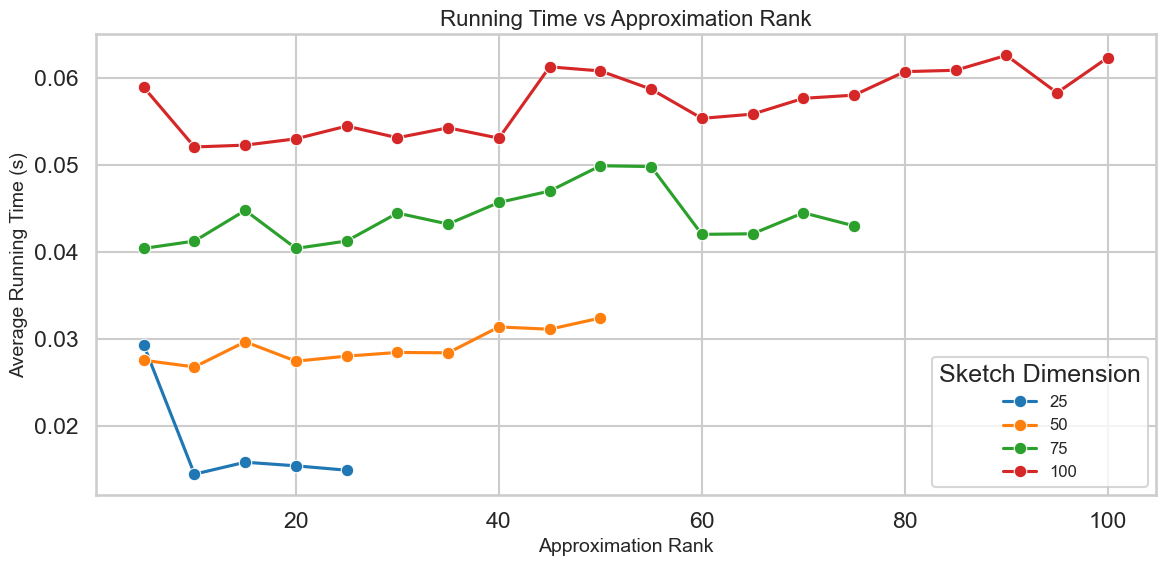

Plot saved to: ../Dataset/Section_4/Section_4_A1_fjlt.png


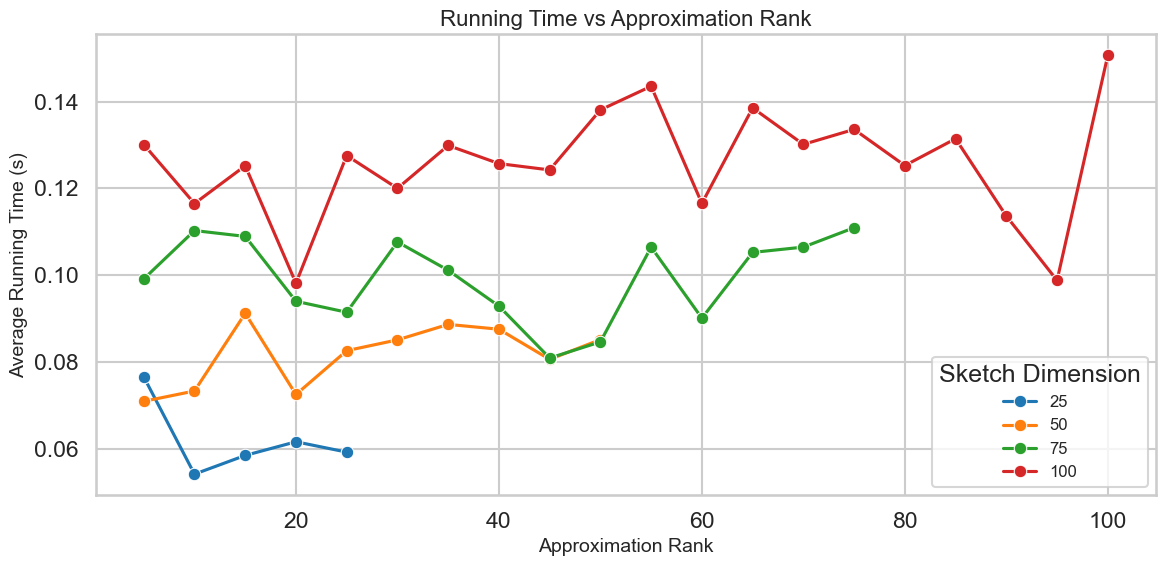

Plot saved to: ../Dataset/Section_4/Section_4_A2_gaussian.png


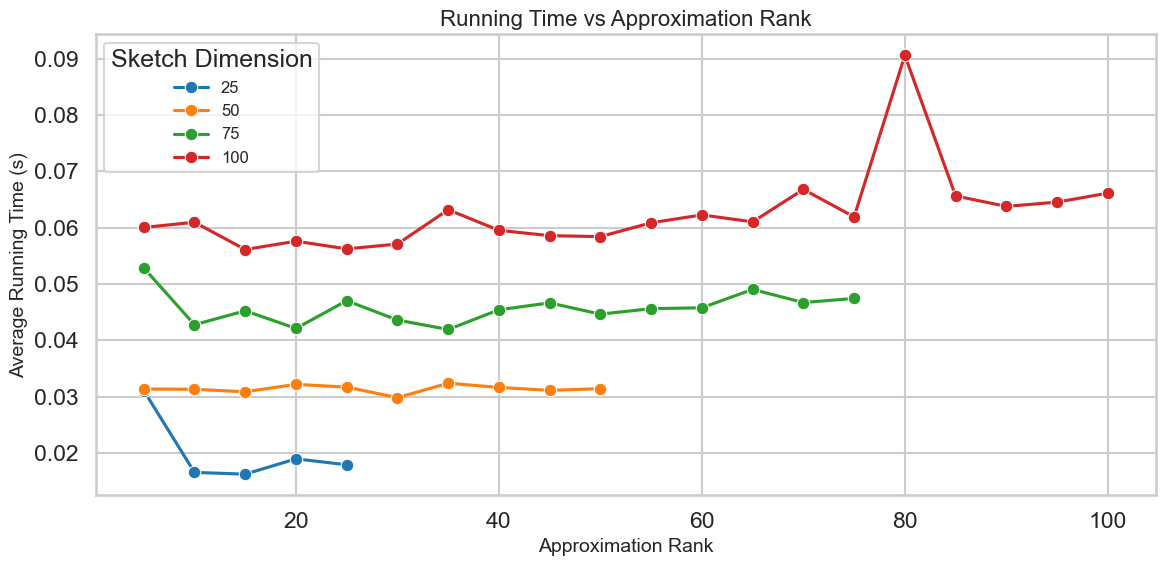

Plot saved to: ../Dataset/Section_4/Section_4_A2_fjlt.png


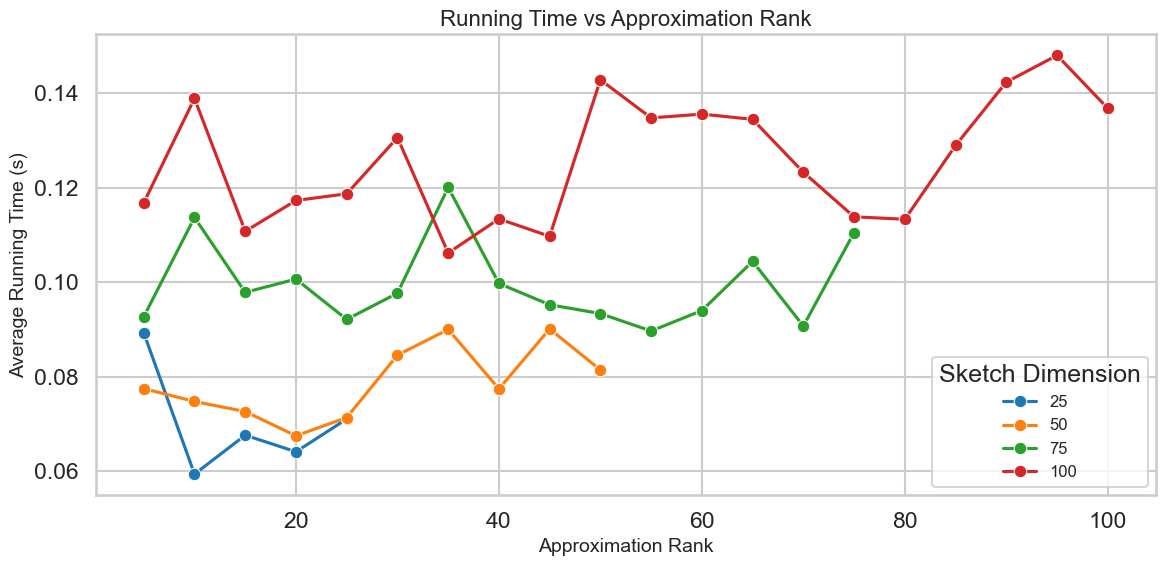

Plot saved to: ../Dataset/Section_4/Section_4_A3_gaussian.png


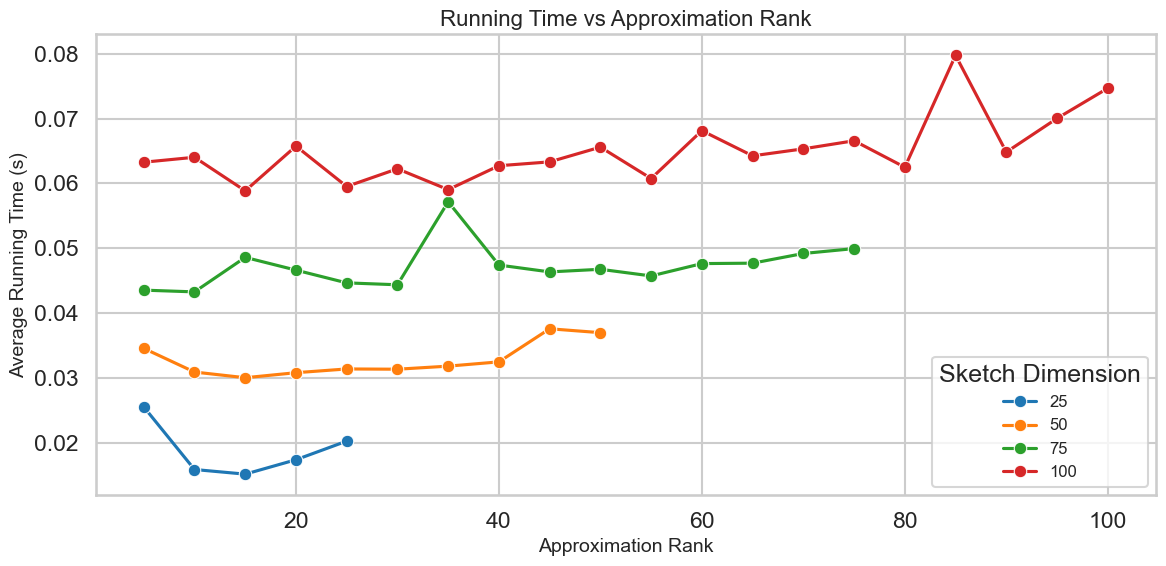

Plot saved to: ../Dataset/Section_4/Section_4_A3_fjlt.png


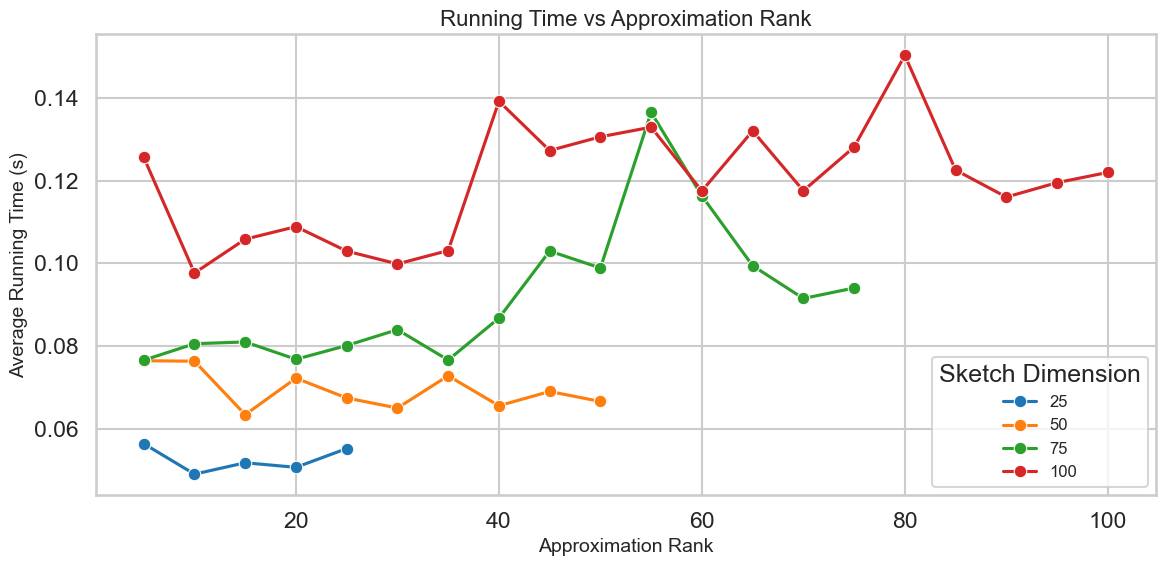

Plot saved to: ../Dataset/Section_4/Section_4_A32_gaussian.png


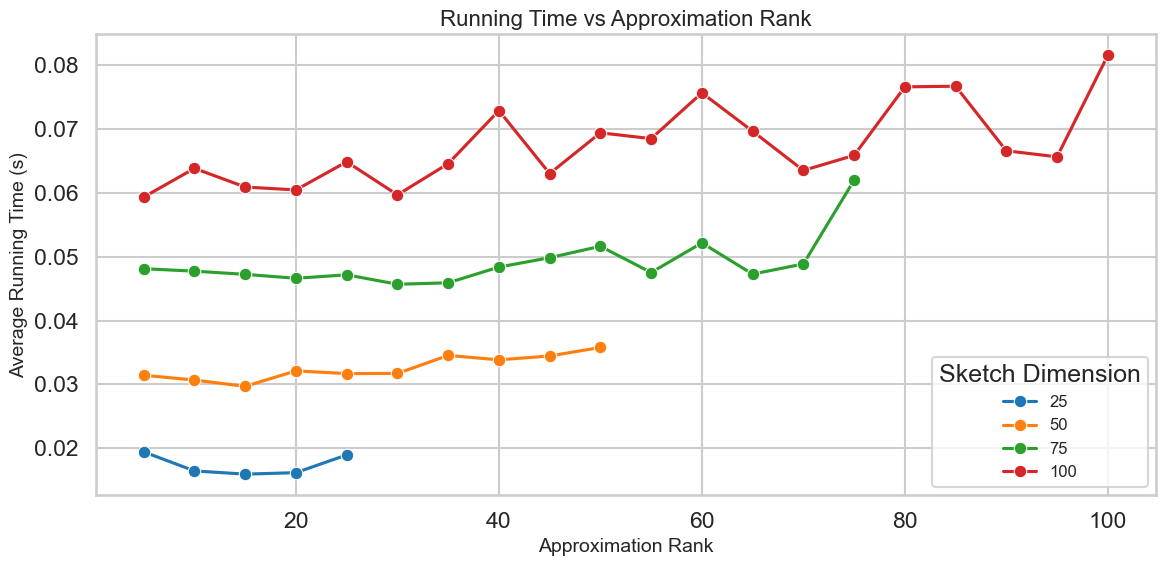

Plot saved to: ../Dataset/Section_4/Section_4_A32_fjlt.png


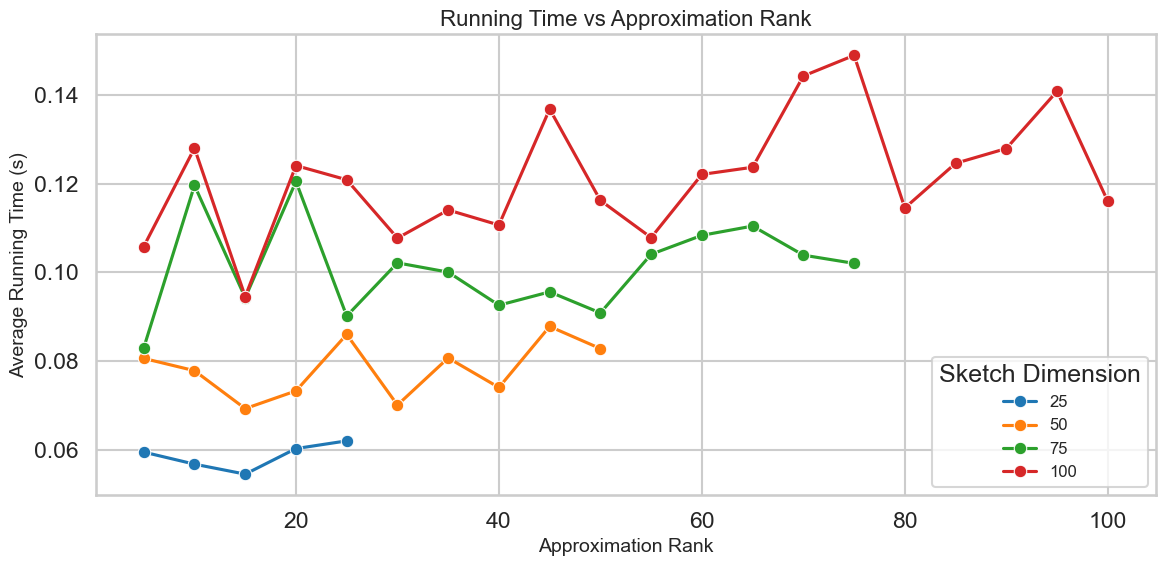

In [24]:
# Use the function
csv_file = "../Dataset/Section_4/Section_4_A1_gaussian.csv"  # Update the path if needed
output_file = "../Dataset/Section_4/Section_4_A1_gaussian.png"  # Specify output folder and file
plot_total_running_time("../Dataset/Section_4/Section_4_A1_gaussian.csv", "../Dataset/Section_4/Section_4_A1_gaussian.png")

# Use the function
plot_total_running_time("../Dataset/Section_4/Section_4_A1_fjlt.csv", "../Dataset/Section_4/Section_4_A1_fjlt.png")


plot_total_running_time('../Dataset/Section_4/Section_4_A2_gaussian.csv', '../Dataset/Section_4/Section_4_A2_gaussian.png')

# Use the function
plot_total_running_time('../Dataset/Section_4/Section_4_A2_fjlt.csv', '../Dataset/Section_4/Section_4_A2_fjlt.png')

plot_total_running_time('../Dataset/Section_4/Section_4_A3_gaussian.csv', '../Dataset/Section_4/Section_4_A3_gaussian.png')

plot_total_running_time('../Dataset/Section_4/Section_4_A3_fjlt.csv', '../Dataset/Section_4/Section_4_A3_fjlt.png')

plot_total_running_time('../Dataset/Section_4/Section_4_A32_gaussian.csv', '../Dataset/Section_4/Section_4_A32_gaussian.png')

plot_total_running_time('../Dataset/Section_4/Section_4_A32_fjlt.csv', '../Dataset/Section_4/Section_4_A32_fjlt.png')



## Section 5

In [39]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

def plot_running_time_dual_axes(csv_file1, csv_file2, output_file):
    # Load the data from CSV files
    df1 = pd.read_csv(csv_file1)
    df2 = pd.read_csv(csv_file2)

    # Combine the two dataframes
    df = pd.concat([df1, df2])

    # Compute the mean running time and numerical error for each (sketch_method, proc_count)
    mean_df = df.groupby(['sketch_method', 'proc_count']).agg({'running_time': 'mean', 'numerical_error': 'mean'}).reset_index()

    # Separate data for gaussian and SRHT (fjlt)
    gaussian_data = mean_df[mean_df['sketch_method'] == 'gaussian']
    srht_data = mean_df[mean_df['sketch_method'] == 'fjlt']

    # Create the figure and axes
    fig, ax1 = plt.subplots(figsize=(10, 6))

    # Plot gaussian data on the first y-axis
    ax1.plot(gaussian_data['proc_count'], gaussian_data['running_time'], 'o-', label='Gaussian', color='blue')
    ax1.set_xlabel('Number of Processors', fontsize=12)
    ax1.set_xticks([4, 16, 64])  # Explicitly set x-axis ticks
    ax1.set_ylabel('Gaussian running time (s)', color='blue', fontsize=12)
    ax1.tick_params(axis='y', labelcolor='blue')
    ax1.yaxis.set_major_locator(MaxNLocator(integer=True))
    ax1.set_ylim(bottom=0)  # Set the bottom limit of y-axis to 0

    # Add the second y-axis
    ax2 = ax1.twinx()
    ax2.plot(srht_data['proc_count'], srht_data['running_time'], 's-', label='SRHT', color='orange')
    ax2.set_ylabel('SRHT running time (s)', color='orange', fontsize=12)
    ax2.tick_params(axis='y', labelcolor='orange')
    ax2.yaxis.set_major_locator(MaxNLocator(integer=True))
    ax2.set_ylim(bottom=0)  # Set the bottom limit of y-axis to 0

    # Add title and grid
    plt.title('Running time comparison', fontsize=14)
    ax1.grid(True, linestyle='--', alpha=0.6)

    # Add mean value labels to each point
    for _, row in gaussian_data.iterrows():
        ax1.text(row['proc_count'], row['running_time'], f"{row['running_time']:.3f}",
                 color='blue', fontsize=10, ha='left', va='bottom')

    for _, row in srht_data.iterrows():
        ax2.text(row['proc_count'], row['running_time'], f"{row['running_time']:.3f}",
                 color='orange', fontsize=10, ha='right', va='top')

    # Save the plot to the specified file
    plt.savefig(output_file, format='png', dpi=300, bbox_inches='tight')
    plt.close()

# Example usage:
# plot_running_time_dual_axes("a1_guassian.csv", "a2_filt.csv", "output.png")


In [40]:
plot_running_time_dual_axes('../src/Helvetios/data_A1_gaussian.csv', '../src/Helvetios/data_A1_srht.csv', 'sec5_A1.png')
plot_running_time_dual_axes('../src/Helvetios/data_A2_gaussian.csv', '../src/Helvetios/data_A2_srht.csv', 'sec5_A2.png')
plot_running_time_dual_axes('../src/Helvetios/data_A3_gaussian.csv', '../src/Helvetios/data_A3_srht.csv', 'sec5_A3.png')
plot_running_time_dual_axes('../src/Helvetios/data_A4_gaussian.csv', '../src/Helvetios/data_A4_srht.csv', 'sec5_A4.png')